#Definitions

##Imports

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.integrate import quad
from scipy import special
from sympy import symbols, Eq, solve, nsolve, exp, integrate, log, Pow, sqrt, pi, lambdify
from scipy.optimize import fsolve
from sympy.plotting import plot
from scipy.optimize import minimize

from ipywidgets import IntProgress
from IPython.display import display, Latex
import time

import warnings
warnings.filterwarnings("ignore")

##$E_0^{\text{cc}}(\rho,r)$ and $\kappa_{s,r}^{\text{cc}}(\rho)$

In [92]:
def E_0_y(y):
  """
    Computes the summation in Gallager's E_0 for a y value
    Arguments:
        y: Channel output (float)
    Returns:
        The result of the summation for a y value, not the complete integral
  """
  suma = 0

  #Sum over all the constellation values  
  for i in range(len(const)):
    suma += probs[i] * np.exp(erre * (const[i]**2 - alpha * E)) * (1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)))**(1/(1+rho))

  return suma**(rho+1)

In [93]:
def comp_exponent(vec):
  """
    Computes the negative version of E_0 in order to minimize it
    Arguments:
        vec: \rho and r (float array)
    Returns:
        The result of -E_0
  """
  global rho, erre

  #Minimize \rho and r
  rho = vec[0]
  erre = vec[1]

  #Compute the ingral over y
  E_0_value, err = quad(E_0_y, -np.inf, np.inf)
  
  #As the exponent is concave, minimize the negative taking into account the
  # linear part of \log(\mu_n(\alpha))
  return -(-np.log(E_0_value) - rho * rate + (rho + 1)*(k - s*alpha*E))

In [94]:
def E_r(R):
  """
    Computes Gallager's E_r
    Arguments:
        R: Rate (float)
    Returns:
        The result of E_r
  """
  global rho, rate, erre

  #Set global variables
  rate = R

  #Minimize the exponent
  res = minimize(comp_exponent, [0.5, 0.5], bounds = ((0,1),(None, None)))
  rho = res.x[0]
  erre = res.x[1]

  #Compute the exponent
  E_0_value, err = quad(E_0_y, -np.inf, np.inf)
  final_res = -np.log(E_0_value) - rho * rate
  
  return final_res

In [95]:
def k_prima_s_num(y):
  """
    Computes the summation in the numerator of \kappa_{s,r}'(\rho) for a y value
    Arguments:
        y: Channel output (float)
    Returns:
        The result the summation in the numerator of \kappa_{s,r}'(\rho) for a y value
  """
  #Set the optimal s value
  s = 1/(1+rho)

  #Sum in the logarithm numerator
  sum = 0
  for i in range(len(const)):
    sum += probs[i] * np.exp(erre * (const[i]**2 - alpha * E)) * (1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)))**s

  #Sum the rest of the expression
  sum2 = 0
  for i in range(len(const)):
    w = 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)) 

     #Exception control for the logarithm (if not is 0 for this y)
    if not (w <= 0 or sum <= 0 or math.isnan(w) or math.isnan(sum)):
      common = probs[i] * np.exp(erre * (const[i]**2 - alpha * E)) * w**(1-s*rho) * sum**rho
      res = common * np.log(sum / w**s)
      
      #More exception control for extreme y cases
      if not math.isnan(res):
        sum2 += res

  return sum2

In [96]:
def k_prima_prima_s_num(y):
  """
    Computes the summation in the numerator of \kappa_{s,r}''(\rho) for a y value
    Arguments:
        y: Channel output (float)
    Returns:
        The result the summation in the numerator of \kappa_{s,r}''(\rho) for a y value
  """
  #Set the optimas s values
  s = 1/(1+rho)

  #Sum in the logarithm numerator
  sum = 0
  for i in range(len(const)):
    sum += probs[i] * np.exp(erre * (const[i]**2 - alpha * E)) * (1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)))**s

  sum2 = 0
  #Sum the rest of the expression
  for i in range(len(const)):
    w = 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)) 

    #Exception control for the logarithm (if not is 0 for this y)
    if not (w <= 0 or sum <= 0 or math.isnan(w) or math.isnan(sum)):
      common = probs[i] * np.exp(erre * (const[i]**2 - alpha * E)) * w**(1-s*rho) * sum**rho
      res = common * np.log(sum / w**s)**2
      
      #More exception control for extreme y cases
      if not math.isnan(res):
        sum2 += res

  return sum2

In [97]:
def solve_k():
  """
    Computes \kappa_{s,r}(\rho)
    Returns:
        The result of \kappa_{s,r}(\rho)
  """
  #Compute the integral
  res, err = quad(E_0_y, -np.inf, np.inf)

  #Return the logarithm
  return np.log(res)

In [98]:
def solve_k_prima():
  """
    Computes \kappa_{s,r}'(\rho)
    Returns:
        The result of \kappa_{s,r}'(\rho)
  """
  #Compute the numerator and denominator
  num, err = quad(k_prima_s_num, -np.inf, np.inf)
  denom = np.exp(solve_k())

  #Exception control (x/0)
  if denom == 0:
    return None

  return num / denom

In [99]:
def solve_k_prima_prima():
  """
    Computes \kappa_{s,r}''(\rho)
    Returns:
        The result of \kappa_{s,r}''(\rho)
  """
  #Compute the numerator and denominator
  num, err = quad(k_prima_prima_s_num, -np.inf, np.inf)
  denom = np.exp(solve_k())

  #Exception control (x/0)
  if denom == 0:
    return None

  return num / denom - solve_k_prima()**2

##$RCU_s(n,M)$

In [100]:
def xi_s(n, pos, k_normal):
  """
    Computes the cumulant function \chi_{s,r}(\rho)
    Arguments:
        n: Sequence length (integer)
        pos: Position of n in \mu_n(\alpha) (integer)
        k_normal: Result of \kappa_{s,r}(\rho) (float)
    Returns:
        The result of \chi_{s,r}(\rho)
  """

  return rho * n * rate + n * k_normal - n * phi() - rho*np.log(mu[pos]) + rho*abs(erre)*delta

In [101]:
def phi():
  """
    Computes \phi(r)
    Returns:
        The result of \phi(r)
  """
  # Sum over constellation values
  sum = 0
  for i in range(len(const)):
    sum += probs[i] * np.exp(erre * (const[i]**2 - alpha * E))

  # Return logarithm
  return np.log(sum)

In [102]:
def rcu_over_n():
  """
    Computes the rcu_{s,r}(n,M) bound over the n_values range
    Returns:
        The result of rcu_{s,r}(n,M) for every n value in the set
  """
  global rho, erre

  # Compute I(Q_r;W)
  bb = solve_mutual()

  # Optimize parameter r
  if rate > bb:
    erre = s
  else:
    res = minimize(fak, [0.5, 0.5], bounds=((0.0, 1.0), (None, None)))
    erre = res.x[1]
  
  # Compute saddlepoint
  res2 = minimize(fak2, [0.5, 0.5], bounds=((-1.0, None), (None, None)))
  rho = res2.x[0]

  #Compute \kappa_{s,r}(\rho) functions
  k_normal = solve_k()
  k_prima_prima = solve_k_prima_prima()

  #Define the array to store the results
  rcu = []

  #Completion bar
  print("Solving rcu bound over n values:")
  f = IntProgress(min=0, max=len(n_values)) # instantiate the bar
  display(f) # display the bar

  #Compute the bounds
  j = 0
  if rho < 0:
    for n in n_values:
      res = np.exp(abs(erre)*delta + n * phi()) / mu[j] * (1.0 + 1/2 * np.exp(xi_s(n, j, k_normal)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2))))
      rcu.append(res)
      j += 1
      f.value += 1
  elif 0 < rho < 1:
    for n in n_values:
      res = 1/2 * np.exp(abs(erre)*delta - np.log(mu[j]) + n*phi() + xi_s(n, j, k_normal)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) + special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))
      rcu.append(res)
      j += 1
      f.value += 1
  else:
    #Compute \kappa_{s,r}(1)
    rho_orig = rho
    rho = 1.0
    k1 = solve_k()
    rho = rho_orig
    
    for n in n_values:
      res = np.exp(n * rate + n * k1 - 2*np.log(mu[j]) + 2*abs(erre)*delta) + 1/2 * np.exp(abs(erre)*delta - np.log(mu[j]) + n*phi() + xi_s(n, j, k_normal)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))
      rcu.append(res)
      j += 1
      f.value += 1

  return rcu

In [103]:
def rcu_over_rate(n, rate_values, rho_values, erre_values):
  """
    Computes the rcu_{s,r}(n,M) bound over the rate_values range
    Arguments:
        n: Sequence length (integer)
        rate_values: Rates (float array)   
        rho_values: \rho for every rate value (float array)
        erre_values: r for every rate value (float array)    
    Returns:
        The result of rcu_{s,r}(n,M) for every rate value in the set
  """
  global rho, erre, rate

  # Define the array to store the results
  rcu = []

  #Completion bar
  print("Solving rcu bound over rate values:")
  f = IntProgress(min=0, max=len(rho_values)) # instantiate the bar
  display(f) # display the bar

  j = 0
  for value in rho_values:
    #Get the parameter and argument values
    rho = value
    rate = rate_values[j]
    erre = erre_values[j]

    #Solve \kappa_{s,r}(\rho) functions
    k_normal = solve_k()
    k_prima_prima = solve_k_prima_prima()

    if rho <= 0:
        res = np.exp(abs(erre)*delta + n * phi()) / mu[-1] * (1.0 + 1/2 * np.exp(xi_s(n, -1, k_normal)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2))))
    elif 0 < rho <= 1:
        res = 1/2 * np.exp(abs(erre)*delta - np.log(mu[-1]) + n*phi() + xi_s(n, -1, k_normal)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) + special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))
    else:
        #Compute \kappa_{s,r}(1)
        rho_orig = rho
        rho = 1.0
        k1 = solve_k()
        rho = rho_orig

        res = np.exp(n * rate + n * k1 - 2*np.log(mu[-1]) + 2*abs(erre)*delta) + 1/2 * np.exp(abs(erre)*delta - np.log(mu[-1]) + n*phi() + xi_s(n, -1, k_normal)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))

    rcu.append(res)
    j += 1
    f.value += 1

  return rcu

In [104]:
def rcu_over_snr(n, sigma_values, rho_values, erre_values):
  """
    Computes the rcu_{s,r}(n,M) bound over the sigma_values range
    Arguments:
        n: Sequence length (integer)
        sigma_values: Noise standard deviation (float array)    
        rho_values: \rho for every sigma value (float array)   
        erre_values: r for every rate value (float array)     
    Returns:
        The result of rcu_{s,r}(n,M) for every sigma value in the set
  """
  global rho, sigma, erre

  # Define the array to store the results
  rcu = []

  # Completion bar
  print("Solving rcu bound over SNR values:")
  f = IntProgress(min=0, max=len(rho_values)) # instantiate the bar
  display(f) # display the bar

  j = 0
  for value in rho_values:
    # Get the parameter and argument values
    rho = value
    sigma = sigma_values[j]
    erre = erre_values[j]

    # Solve \kappa_{s,r}(\rho) functions
    k_normal = solve_k()
    k_prima_prima = solve_k_prima_prima()

    # Compute the bounds
    if rho <= 0:
        res = np.exp(abs(erre)*delta + n * phi()) / mu[-1] * (1.0 + 1/2 * np.exp(xi_s(n, -1, k_normal)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2))))
    elif 0 < rho <= 1:
        res = 1/2 * np.exp(abs(erre)*delta - np.log(mu[-1]) + n*phi() + xi_s(n, -1, k_normal)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) + special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))
    else:
        #Compute \kappa_{s,r}(1)
        rho_orig = rho
        rho = 1.0
        k1 = solve_k()
        rho = rho_orig

        res = np.exp(n * rate + n * k1 - 2*np.log(mu[-1]) + 2*abs(erre)*delta) + 1/2 * np.exp(abs(erre)*delta - np.log(mu[-1]) + n*phi() + xi_s(n, -1, k_normal)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))
    
    rcu.append(res)
    j += 1

    f.value += 1

  return rcu

In [105]:
def rcu_exact():
  """
    Computes the exact rcu_{s,r}(n,M) bound
    Returns:
        The result of the exact rcu_{s,r}(n,M)
  """
  global rho, erre

  # Compute I(Q_r;W)
  bb = solve_mutual()

  # Optimize parameter r
  if rate > bb:
    erre = s
  else:
    res = minimize(fak, [0.5, 0.5], bounds=((0.0, 1.0), (None, None)))
    erre = res.x[1]
  
  # Compute saddlepoint
  res2 = minimize(fak2, [0.5, 0.5], bounds=((-1.0, None), (None, None)))
  rho = res2.x[0]

  #Compute \kappa_{s,r}(\rho) functions
  k_normal = solve_k()
  k_prima_prima = solve_k_prima_prima()

  #Compute the bounds
  j = -1
  if rho < 0:
    res = np.exp(abs(erre)*delta + n * phi()) / mu[j] * (1.0 + 1/2 * np.exp(xi_s(n, j, k_normal)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2))))
  elif 0 < rho < 1:
    res = 1/2 * np.exp(abs(erre)*delta - np.log(mu[j]) + n*phi() + xi_s(n, j, k_normal)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) + special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))
  else:
    #Compute \kappa_{s,r}(1)
    rho_orig = rho
    rho = 1.0
    k1 = solve_k()
    rho = rho_orig
    
    res = np.exp(n * rate + n * k1 - 2*np.log(mu[j]) + 2*abs(erre)*delta) + 1/2 * np.exp(abs(erre)*delta - np.log(mu[j]) + n*phi() + xi_s(n, j, k_normal)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))

  return res

##Gallager bound

In [106]:
def gallager_over_n():
  """
    Computes the Gallager bound over the n_values range
    Returns:
        The result of the Gallager bound for every n value in the set
  """
  # Define the array to store the results
  gallager_values = []

  # Compute the exponent
  E_r_value = E_r(rate)

  # Completion bar
  print("Solving gallager bound over n values:")
  f = IntProgress(min=0, max=len(n_values)) # instantiate the bar
  display(f) # display the bar

  # Compute the bound
  i = 0
  for n in n_values:
    val = (np.exp(abs(erre)*delta)/mu[i])**(1+rho) * np.exp(-n * E_r_value)
    gallager_values.append(val)
    i += 1
    f.value += 1

  return gallager_values

In [107]:
def gallager_over_rate(n, rate_values):
  """
    Computes the Gallager bound over the rate_values range
    Arguments:
        n: Sequence length (integer)
        rate_values: Rates (float array)
    Returns:
        The result of the Gallager bound for every rate value in the set
  """
  # Define the array to store the results
  gallager_values = []

  # Completion bar
  print("Solving gallager bound over rate values:")
  f = IntProgress(min=0, max=len(rate_values)) # instantiate the bar
  display(f) # display the bar

  # Compute the bound
  for r in rate_values: 
    E_r_value = E_r(r) # Compute the exponent
    val = (np.exp(abs(erre)*delta)/mu[-1])**(1+rho) * np.exp(-n * E_r_value)
    gallager_values.append(val)
    f.value += 1

  return gallager_values

In [108]:
def gallager_over_snr(rate, n, sigma_values):
  """
    Compute the Gallager bound over the sigma_values range
    Arguments:
        rate: Rate (float)
        n: Sequence length (integer)
        sigma_values: Sigma values (float array)
    Returns:
        The result of the Gallager bound for every sigma value in the set
  """
  global sigma

  # Define the array to store the results
  gallager_values = []

  # Completion bar
  print("Solving gallager bound over SNR values:")
  f = IntProgress(min=0, max=len(sigma_values)) # instantiate the bar
  display(f) # display the bar

  # Compute the bound
  for s in sigma_values: 
    sigma = s
    E_r_value = E_r(rate) # Compute the exponent
    val = (np.exp(abs(erre)*delta)/mu[-1])**(1+rho) * np.exp(-n * E_r_value)
    gallager_values.append(val)
    f.value += 1

  return gallager_values

In [109]:
def gallager_exact():
  """
    Computes the exact Gallager bound
    Returns:
        The result of the exact Gallager
  """
  # Compute the exponent
  E_r_value = E_r(rate)

  # Compute the bound
  i = -1
  val = (np.exp(abs(erre)*delta)/mu[i])**(1+rho) * np.exp(-n * E_r_value)

  return val

##$\rho$ and $r$ calculators

In [110]:
def fak(x):
  """
    Computes the exponent to minimize to find r
    Arguments:
        x: \rho and r (float array)
    Returns:
        The result of the exponent to minimize
  """
  global rho, erre
  
  # Set the values
  rho = x[0]
  erre = x[1]

  # Compute the exponent with also the linear part of \log(\mu_n(\alpha))
  return rho * rate + solve_k() - (rho + 1)*(k - s*alpha*E) 

In [111]:
def fak2(x):
  """
    Computes the exponent to minimize for the rcu_{s,r}(n,M) over \rho
    Arguments:
        x: \rho
    Returns:
        The result of the exponent to minimize
  """
  global rho
  
  # Set the value
  rho = x[0]

  # Compute the exponent with also the linear part of \log(\mu_n(\alpha))
  return rho * rate + solve_k() - phi() - (rho + 1)*(k - s*alpha*E)

In [112]:
def rho_erre_per_rate(rate_values):
  """
    Computes corresponding \rho and r values for every rate value
    Arguments:
        rate_values: Rates (float array)
    Returns:
        An array with every \rho and r value found
  """
  global rho, erre, rate

  # Define the arrays to store the results
  rho_values = []
  erre_values = []
  
  # Completion bar
  print("Solving saddlepoint rho for every rate value:")
  f = IntProgress(min=0, max=len(rate_values)) # instantiate the bar
  display(f) # display the bar

  # Optimize \rho and r
  for r in rate_values:
    rate = r

    if rate > mutual_inf:
      erre = s
    else:
      res = minimize(fak, [0.5, 0.5], bounds=((0.0, 1.0), (None, None)))
      erre = res.x[1]

    # 2D minimization that is in fact 1D, but to set the bounds it has to be this way
    res2 = minimize(fak2, [0.5, 0.5], bounds=((-1.0, None), (None, None)))
    rho = res2.x[0]

    rho_values.append(rho)
    erre_values.append(erre)
    f.value += 1

  return rho_values, erre_values

In [113]:
def rho_erre_per_sigma(sigma_values):
  """
    Computes corresponding \rho and r values for every sigma value
    Arguments:
        sigma_values: Sigma values (float array)
    Returns:
        An array with every \rho and r value found
  """
  global rho, erre, sigma

  # Define the arrays to store the results
  rho_values = []
  erre_values = []

  # Completion bar
  print("Solving saddlepoint rho for every SNR value:")
  f = IntProgress(min=0, max=len(sigma_values)) # instantiate the bar
  display(f) # display the b

  # Optimize \rho and r
  for a in sigma_values:
    sigma = a

    # Compute I(Q_r;W)
    bb = solve_mutual()

    # Optimize the r value
    if rate > bb:
      erre = s
    else:
      res = minimize(fak, [0.5, 0.5], bounds=((0.0, 1.0), (None, None)))
      erre = res.x[1]

    # 2D minimization that is in fact 1D, but to set the bounds it has to be this way
    res2 = minimize(fak2, [0.5, 0.5], bounds=((-1.0, None), (None, None)))
    rho = res2.x[0]

    rho_values.append(rho)
    erre_values.append(erre)
    f.value += 1
    
  return rho_values, erre_values

##Modulation generation

In [114]:
def maxwell_boltzmann_const(lambda_dist, pam_const):
  """
    Generates the modulation values as well as their probabilities
    Arguments:
        lambda_dist: \lambda (float)
        pam_const: Base modulation values (float array)
    Returns:
        The modulation values, their probabilities, the interval value and the mean energy
  """
  # Define the symbolic variable
  x = symbols('x')
 
  #Define the expression to solve
  denom = 0
  for value in pam_const:
    denom += exp(-lambda_dist * abs(value * x)**2)
  expression = 0
  for value in pam_const:
    expression += abs(value * x)**2 * exp(-lambda_dist * abs(value * x)**2) / denom

  #Solve the equation
  try:
    interval = float(abs(nsolve(expression - E, x, 0.1))) #INTERVAL
  except:
    func_np = lambdify(x, expression - E, modules=['numpy'])
    if lambda_dist <= 0.5 / E:
      x0 = min(0.001 * np.sqrt(E), lambda_dist)
    else:
      x0 = max(0.9 * np.sqrt(E), lambda_dist)
    interval = abs(fsolve(func_np, x0)) #INTERVAL

  #CONSTELLATION
  const = []
  for i in pam_const:
    const.append(i * interval)

  #PROB DISTRIBUTION
  probs = []
  denom = 0
  for value in const:
    denom += np.exp(-lambda_dist * abs(value)**2)
  for value in const:
    probs.append(np.exp(-lambda_dist * abs(value)**2) / denom)

  #AVERAGE ENERGY
  energy = 0
  j = 0
  for i in const:
    #energy += i**2*np.exp(-lambda_dist * abs(i)**2) / denom 
    energy += i**2*probs[j]
    j += 1

  return const, probs, interval, energy 

In [115]:
def define_constellation(pam, lambda_dist):
  """
    Generates the modulation values as well as their probabilities
    Arguments:
        lambda_dist: \lambda (float)
        pam: M for the M-PAM modulation (integer)
    Returns:
        The modulation values, their probabilities, the interval value and the mean energy
  """
  # Define the base constellation
  pam_const = []
  for i in range(-pam+1, pam):
    if i%2 != 0: 
      pam_const.append(i)

  #Generate constellation
  const, probs, interval, energy = maxwell_boltzmann_const(lambda_dist, pam_const)

  #Show results
  display(Latex('\Delta = %f' %interval))
  display(Latex('\mathcal{E} = %f' %energy))
  plt.title("Constellation $\\psi$ values with distribution $Q_{iid}(x)$")
  plt.stem(const, probs)
  plt.xlabel("$\\psi$")
  plt.ylabel("$Q_{iid}(x)$")
  plt.show()

  return const, probs, interval, energy

##Basic functions

In [116]:
def rcu_gallager_computation(rate_values, sigma_values, n, rate):
  """
    Computes the bound values for the selected mode
    Arguments:
        rate_values: Rates (float array)
        sigma_values: Sigma values (float array)
        n: Sequence length (integer)
        rate: Rate (float)
    Returns:
        The bound values for the selected mode
  """
  global rho, mutual_inf, cr

  #Set initial paramters
  rho = 0.0

  #Compute the bounds for every mode
  rcu_assimp = []
  if mode == 0:
    rcu = rcu_over_n()
    gallager_values = gallager_over_n()

  elif mode == 1:
    mutual_inf, cr = mi_cr()
    rho_values, erre_values = rho_erre_per_rate(rate_values)
    rcu = rcu_over_rate(n, rate_values, rho_values, erre_values)
    gallager_values = gallager_over_rate(n, rate_values)

  elif mode == 2:
    rho_values, erre_values = rho_erre_per_sigma(sigma_values)
    rcu = rcu_over_snr(n, sigma_values, rho_values, erre_values)
    gallager_values = gallager_over_snr(rate, n, sigma_values)

  elif mode == 3:
    mutual_inf, critical_rate = mi_cr()
    rcu = rcu_exact()
    gallager_values = gallager_exact()

  else:
    raise SystemExit("Incorred mode selected")

  return rcu, gallager_values

In [117]:
def plot_results():
  """
    Plots and saves the results for the selected mode
  """
  if mode == 0:
    plt.plot(n_values, rcu)
    plt.plot(n_values, gallager_values)
    plt.ylabel("$P_{e}(n,M)$ bounds")
    plt.xlabel("$n$")
    if log_view:
      plt.yscale("log")
    plt.legend(["$rcu_{s,r}(n,M)$", "Gallager"])
    plt.show()

    if save_data:
      data = np.column_stack([n_values, rcu, gallager_values])
      np.savetxt("upper_bounds_over_n.txt", data, fmt='%.8e', delimiter="  ")

  if mode == 1:
    plt.plot(rate_values, rcu)
    plt.plot(rate_values, gallager_values)
    plt.ylabel("$P_{e}(n,M)$ bounds")
    plt.xlabel("$R$")
    if log_view:
      plt.yscale("log")

    leg = []
    if mutual_inf < max(rate_values):
      plt.axvline(x=mutual_inf, color='k', linestyle='--')
      leg.append("$I(Q;W)$")
    if cr > min(rate_values):
      plt.axvline(x=cr, color='g', linestyle='--')
      leg.append("$R_c(Q_r;W)-\\varphi(\hat{r}_1)+\kappa(\hat{s})-\hat{s}\\alpha\\mathcal{E}$")

    plt.legend(["$rcu_{s,r}(n,M)$", "Gallager"] + leg, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    if save_data:
      for i in range(len(rcu), len(rate_values)):
        rcu.append(1.0)
      data = np.column_stack([rate_values, rcu, gallager_values])
      np.savetxt("upper_bounds_over_rate.txt", data, fmt='%.8e', delimiter="  ")

  if mode == 2:
    snr_values = []
    for val in sigma_values:
      snr_values.append(10 * np.log10(E / val**2)) #The SNR in dB
      
    plt.plot(snr_values, rcu)
    plt.plot(snr_values, gallager_values)
    plt.ylabel("$Pe(n,M)$ bounds")
    plt.xlabel("$snr ($dB$)$")
    if log_view:
      plt.yscale("log")
    plt.legend(["$rcu_{s,r}(n,M)$", "Gallager"])
    plt.show()

    if save_data:
      data = np.column_stack([snr_values, rcu, gallager_values])
      np.savetxt("upper_bounds_over_snr.txt", data, fmt='%.8e', delimiter="  ")
    
  if mode == 3:
    display(Latex('rcu_s(n,M):'))
    print(rcu)
    display(Latex('e^{-n(E_0(\\rho) - \\rho R)}:'))
    print(gallager_values)

##$\mu_n(\alpha)$

In [118]:
def check_newton(x):
  """
    Checks is the solution found by the Newton method is correct
    Arguments:
        x: The solution value (float)
    Returns:
        The result of the equation
  """
  global s

  # Set s as the solution
  s = x

  # Return the solution
  return solve_k_prima_mu() - alpha * E

In [119]:
def solve_k_mu():
  """
    Computes the cumulant function \kappa(s)
    Returns:
        The result of \kappa(s)
  """
  # Sum over all constellation values
  result = 0
  for i in range(len(const)):
    result += probs[i] * np.exp(s * const[i]**2)
  
  #Compute the logarithm 
  k = np.log(result)
  return k

def solve_k_prima_mu():
  """
    Computes \kappa'(s)
    Returns:
        The result of \kappa'(s)
  """
  # Sum over all constellation values
  num = 0
  denom = 0
  for i in range(len(const)):
    num += probs[i] * np.exp(s * const[i]**2) * const[i]**2
    denom += probs[i] * np.exp(s * const[i]**2)

  k_prima = num / denom
  return k_prima

def solve_k_prima_prima_mu():
  """
    Computes \kappa''(s)
    Returns:
        The result of \kappa''(s)
  """
  # Sum over all constellation values
  num1 = 0
  num2 = 0
  num3 = 0
  denom = 0
  for i in range(len(const)):
    num1 += probs[i] * np.exp(s * const[i]**2) * const[i]**4
    num2 += probs[i] * np.exp(s * const[i]**2)
    num3 += probs[i] * np.exp(s * const[i]**2) * const[i]**2
    denom += probs[i] * np.exp(s * const[i]**2)
    
  k_prima_2 = (num1 * num2 - num3**2) / denom**2
  return k_prima_2

In [120]:
def newton_mu(f, Df, epsilon, max_iter):
  """
    Saddlepoint for \mu_n(\alpha) solver
    Arguments:
        f: Function to minimize (function)
        Df: Derivative of the function to minimize (function)
        epsilon: Precision of the solution (float)
        max_iter: Maximum number of iterations (integer)
    Returns:
        The \hat s solution for the saddlepoint
  """
  global s

  for m in range(0,max_iter):
      #First evaluate the function
      val = f()
      if val == None: #If there is no result, return
        return None

      # Compute the result of the equation (= 0)
      fxn = val - alpha * E

      # If it is close enough to zero, is solved
      if abs(fxn) < epsilon:
          return
        
      # Compute the derivative
      Dfxn = Df()
      if Dfxn == 0 or Dfxn == None: #If there is no result, return
          return None

      # Set the new s value
      s = s - fxn/Dfxn

      if math.isnan(s): #If there is no result, return
          return None
          
  #If there is no result, return    
  return None

In [121]:
def pos_values(lst):
  """
    Obtain only the positive values of an array
    Arguments:
        lst: a float or integer array
    Returns:
        An array with only the positive values of lst
  """
  a = lst # Copy to not change the original
  return [x for x in a if x > 0] or None

def main_values(delta, n, h):
  """
    Computes the limit values for the summation in the lattice case
    Arguments:
        delta: \delta (float)
        n: Sequence length (integer)
        h: Span (float)
    Returns:
        The limit values for the summation in the lattice case and the interval \Delta
  """
  # Compute the extreme values
  z_min = pos_values(const)[0]**2 * n
  z_minimum = pos_values(const)[0]**2 * n
  z_max = pos_values(const)[-1]**2 * n

  i = 0
  found = 0
  # Traverse all the range of values
  while z_min + i*h <= n * alpha * E + delta:
    # Border of the maximum value
    if z_min + (i+1)*h > n * alpha * E + delta and z_min + i*h <= n * alpha * E + delta:
      z_max = z_min + i*h

    # Border of the minimum value
    if z_min + (i+1)*h >= n * alpha * E - delta and z_min + i*h < n * alpha * E - delta:
      z_minimum = z_min + (i+1)*h

    # FInd interval value
    if z_min + (i+1)*h > n * alpha * E and z_min + i*h <= n * alpha * E:
      interval = n * alpha * E - (z_min + i*h)
      found = 1

    i += 1

  # Set an interval if not found
  if not found:
    interval = 0

  # Compute summation limit values
  i0 = -(n * alpha * E - interval - z_minimum) / h
  i_n = (z_max - (n * alpha * E - interval)) / h

  return interval, i0, i_n

In [122]:
def mu_n(alpha, interval, i0, i_n, k, k_prima_2, s, z_max, z_min):
  """
    Computes \mu_n(\alpha) for the indicate n value
    Arguments:
        alpha: \alpha (float)
        interval: \delta (float)
        i0: Lower summation limit (integer)
        in: Upper summation limit (integer)
        k: \kappa(\hat s) (float)
        k_prima_2: \kappa''(\hat s) (float)
        s: \hat s (float)
        z_max: Maximum value of Z (float)
        z_min: Minimum value of Z (float)
    Returns:
        The result of \mu_n(\alpha) for the given n
  """ 
  # Compute the prefactor of the exponential function
  prefactor = np.exp(n * k - s * (n * alpha * E)) * h / np.sqrt(2 * np.pi * n * k_prima_2)

  # Compute the sum
  sum1 = 0
  if math.isnan(s) or n * alpha * E + delta > z_max: # Check if we are out of limits or no s has been found
    sum1 = 1.0
  else:
    for i in range(i0, i_n+1):
      sum1 += np.exp(-s * i * h) * np.exp(-(- interval + i * h)**2 / (2 * n * k_prima_2))
    sum1 *= prefactor * np.exp(-s * (- interval))

  return sum1

In [123]:
def mu_discrete(delta, h):
  """
    Computes \mu_n(\alpha) for all the range of n values (lattice case)
    Arguments:
        delta: \delta (float)
        h: Span (float)
    Returns:
        The result of \mu_n(\alpha) for all the range of n values
  """
  global s, n, k, k_prima_2

  #Compute the saddlepoint \hat s
  s = 0.0
  newton_mu(solve_k_prima_mu, solve_k_prima_prima_mu, 1e-8, 100)

  # Check if the result is correct (in some cases no solution is found)
  if math.isnan(abs(check_newton(s))) or abs(check_newton(s)) > 1e-7 :
   print("No solution found for selected:")
   display(Latex('\\alpha = %f' %alpha))
   display(Latex('\delta = %f' %delta))
   display(Latex('\lambda = %f' %lambda_dist))
   raise SystemExit("Enter new parameters")

  # Solve \kappa(\hat s) functions
  k = solve_k_mu()
  k_prima = solve_k_prima_mu()
  k_prima_2 = solve_k_prima_prima_mu()  

  # Define the array to store the values and the Z limits for n=1
  mu = []
  z_min = pos_values(const)[0]**2
  z_max = pos_values(const)[-1]**2

  # Compute mu_n(\alpha0) over n
  for i in n_values:
    # Set the n value and the limits for n
    n = i
    z_min_n = z_min * n
    z_max_n = z_max * n

    # Compute the summation limits
    interval, i0, i_n = main_values(delta, n, h)
    
    # Compute mu_n(\alpha) for a certain n value
    mu.append(mu_n(alpha, interval, int(np.round(i0)), int(np.round(i_n)), k, k_prima_2, s, z_max_n, z_min_n))

  return mu

In [124]:
def mu_continous():
  """
    Computes \mu_n(\alpha) for all the range of n values (continuous case)
    Arguments:
        delta: a float
        h: a float
    Returns:
        The result of \mu_s(\alpha) for all the range of n values
  """
  global s, n, k, k_prima_2

  # Compute the saddlepoint \hat s
  s = 0.0
  newton_mu(solve_k_prima_mu, solve_k_prima_prima_mu, 1e-8, 100)
  
  # Check if the result is correct (in some cases no solution is found)
  if math.isnan(abs(check_newton(s))) or abs(check_newton(s)) > 1e-7 :
   print("No solution found for selected:")
   display(Latex('\\alpha = %f' %alpha))
   display(Latex('\delta = %f' %delta))
   display(Latex('\lambda = %f' %lambda_dist))
   raise SystemExit("Enter new parameters")

  # Solve \kappa(\hat s) functions
  k = solve_k_mu()
  k_prima = solve_k_prima_mu()
  k_prima_2 = solve_k_prima_prima_mu()  

  # Define the array to store the values and the Z limits for n=1
  mu = []
  z_min = pos_values(const)[0]**2
  z_max = pos_values(const)[-1]**2

  # Compute mu_n(\alpha0) over n
  erfcx_calc = True # Vale to compute the asymptotic approximation
  for i in n_values:
    # Set the n value and the limits for n
    n = i
    z_min_n = z_min * n
    z_max_n = z_max * n

    # Compute the values of the erfcx functions
    x1 = (s*n*k_prima_2 + delta) / (np.sqrt(2*n*k_prima_2))
    x2 = (s*n*k_prima_2 - delta) / (np.sqrt(2*n*k_prima_2))

    # Compute both versions
    if erfcx_calc:
      mu_val_erfcx = np.exp(n * (k - s * alpha * E)) * 1/2 * np.exp(-(delta**2/(2*n*k_prima_2))) * (special.erfcx(x2)*np.exp(delta*s) - special.erfcx(x1)*np.exp(-delta*s))
    mu_val_assymp = np.exp(n * (k - s * alpha * E)) * np.exp((n*k_prima_2*s**2)/2) / 2 * (np.exp(-x2**2)/(np.sqrt(np.pi)*x2) - np.exp(-x1**2)/(np.sqrt(np.pi)*x1))

    # If the asymptotic is close enough, change to it
    if erfcx_calc and abs(mu_val_assymp - mu_val_erfcx) < 1e-16:
      erfcx_calc = False

    # Add the result to the array
    if erfcx_calc:
      mu.append(mu_val_erfcx)
    else:
      mu.append(mu_val_assymp)

  if math.isnan(mu[-1]):
    print("No probability approximation could be done")
    display(Latex('\\alpha = %f' %alpha))
    display(Latex('\delta = %f' %delta))
    display(Latex('\lambda = %f' %lambda_dist))
    raise SystemExit("Enter new parameters")

  return mu

In [125]:
def compute_mu_n(delta):
  """
    Computes \mu_n(\alpha) for all the range of n values selecting the case by
    the characteristics of the modulation
    Arguments:
        delta: \delta (float)
    Returns:
        The result of \mu_s(\alpha) for all the range of n values
  """
  global h
  
  # Set the span
  h = 8/5 * E

  # Select the case
  mu = []
  if pam == 4:
    mu = mu_discrete(delta, h)
  else:
    mu = mu_continous()

  # Show the results
  plt.plot(n_values, mu)
  plt.yscale("log")
  plt.xlabel("$n$")
  plt.ylabel("$\\mu_n(\\alpha)$")

  return mu

##$I(Q_r;W)$ and $R_c(Q_r;W)$

In [126]:
def mutual(y):
  """
    Computes the summation in I(Q_r;W) for a y value
    Arguments:
        y: Channel output (float)
    Returns:
        The result of the summation in I(Q_r;W) for a y value
  """
  global rho, erre
  
  # Set \rho, s and r
  rho = 0
  s_exp  = 1/(1+rho)
  erre = s
  
  # Sum in the logarithm numerator
  sum = 0
  for i in range(len(const)):
    sum += probs[i] * np.exp(erre * (const[i]**2 - alpha * E) - phi()) * (1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)))**s_exp 

  # Sum the rest of the expression
  sum2 = 0
  for i in range(len(const)):
    w = 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)) 

    # Exception control for the logarithm (if not is 0 for this y)
    if not (w <= 0 or sum <= 0 or math.isnan(w) or math.isnan(sum)):
      common = probs[i] * np.exp(erre * (const[i]**2 - alpha * E) - phi()) * w**(1-s_exp*rho) * sum**rho
      res = common * np.log(sum / w**s_exp)
      
      # More exception control for extreme y cases
      if not math.isnan(res):
        sum2 += res

  return -sum2

In [127]:
def critical_rate_num(y):
  global rho
  """
    Computes the summation in the numerator in R_c(Q_r;W) for a y value
    Arguments:
        y: Channel output (float)
    Returns:
        The result of the summation in the numerator in R_c(Q_r;W) for a y value
  """
  # Set \rho, s and r
  rho = 1.0
  s_exp  = 1/(1+rho)
  
  # Sum in the logarithm numerator
  sum = 0
  for i in range(len(const)):
    sum += probs[i] * np.exp(erre * (const[i]**2 - alpha * E) - phi()) * (1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)))**s_exp 

  # Sum the rest of the expression
  sum2 = 0
  for i in range(len(const)):
    w = 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)) 

    # Exception control for the logarithm (if not is 0 for this y)
    if not (w <= 0 or sum <= 0 or math.isnan(w) or math.isnan(sum)):
      common = probs[i] * np.exp(erre * (const[i]**2 - alpha * E) - phi()) * w**(1-s_exp*rho) * sum**rho
      res = common * np.log(sum / w**s_exp)
      
      # More exception control for extreme y cases
      if not math.isnan(res):
        sum2 += res

  return -sum2

In [128]:
def solve_mutual():
  """
    Computes I(Q_r;W)
    Returns:
        The result of I(Q_r;W)
  """
  #Compute the integral
  res, err = quad(mutual, -np.inf, np.inf)

  return res

In [129]:
def solve_critical_rate():
  """
    Computes R_c(Q_r;W)-\\varphi(\hat{r}_1)+\kappa(\hat{s})-\hat{s}\\alpha\\mathcal{E}
    Returns:
        The result of R_c(Q_r;W)-\\varphi(\hat{r}_1)+\kappa(\hat{s})-\hat{s}\\alpha\\mathcal{E}
  """
  global rho, erre

  # Optimize and r
  rho = 1.0
  res = minimize(fak, [1.0, 0.5], bounds=((1.0, 1.0), (None, None)))
  erre = res.x[1]

  res_num, err = quad(critical_rate_num, -np.inf, np.inf)
  res_denom = np.exp(solve_k() - phi())
  res = res_num/res_denom  - phi() + k - s * alpha * E

  return res

In [130]:
def mi_cr():
  """
    Computes the frontier values
    Returns:
        The the frontier values
  """
  mutual_inf = solve_mutual()
  cr = solve_critical_rate()

  # Show the results
  display(Latex('I(Q_{\hat{r}_0};W) = %f' %mutual_inf))
  display(Latex('R_c(Q_{\hat{r}_1};W) -\\varphi(\hat{r}_1)+\kappa(\hat{u})-\hat{u}\\alpha\\mathcal{E} = %f' %cr))

  return mutual_inf, cr

#CONFIGURATION

In [131]:
#MODE (0: over n - 1: over R - 2: over SNR - 3: Exact result)
mode = 1

#CONSTELLATION
pam = 8

#SNR
E = 1.0
if mode == 0 or mode == 1 or mode == 3: # For modes 0, 1 and 3
  sigma = 1.0
  sigma_values = sigma
else: # For mode 2
  sigma_sq0 = 3.5
  sigma_sq1 = 0.25
  sigma_values = np.linspace(np.sqrt(sigma_sq0), np.sqrt(sigma_sq1), dtype = float, num = 25)

#RATE
rate = 0.5
rate_values = np.linspace(0.01, rate, dtype = float, num = 25)

#N VALUES
n = 1000
n_values = np.linspace(1, n, dtype = int, num = 100)

#MAXWELLL-BOLTZMANN LAMBDA
lambda_dist = 0.4999

#RANGE
alpha = 0.6
delta = 20

#LOG VIEW
log_view = True

#SAVE DATA
save_data = True

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

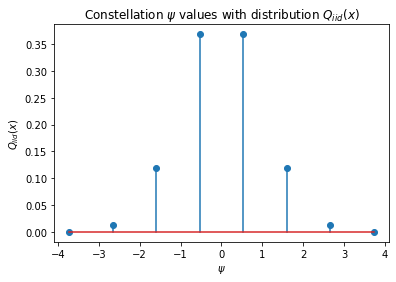

In [132]:
const, probs, interval, energy = define_constellation(pam, lambda_dist)

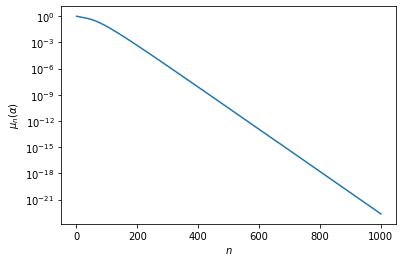

In [133]:
mu = compute_mu_n(delta)

#$Pe(n,M)$ bounds

In [134]:
rcu, gallager_values = rcu_gallager_computation(rate_values, sigma_values, n, rate)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Solving saddlepoint rho for every rate value:


IntProgress(value=0, max=25)

Solving rcu bound over rate values:


IntProgress(value=0, max=25)

Solving gallager bound over rate values:


IntProgress(value=0, max=25)

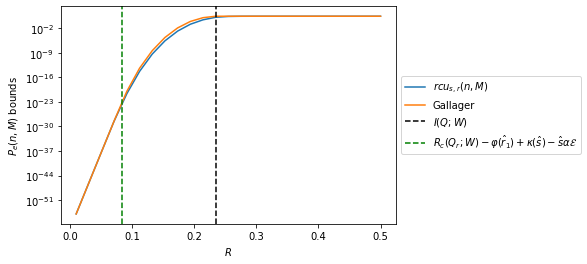

In [135]:
plot_results()